In [1]:
import random
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
length = 1000
cols = ["Q", "X", "Y", "Z"]
mu = 0
sigma = 5


import pingouin
lst_dct = {col:[] for col in cols }
for i in range(length):
    lst_dct["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dct["X"].append(5 * lst_dct["Q"][-1] + 10 + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -3 + 20 +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(5 * lst_dct["X"][-1] + 10 * lst_dct["Y"][-1] +  np.random.normal(mu, 3 * sigma))

df = pd.DataFrame(lst_dct)
keys = ["X",
        "Y",
        "Z",
        "Q"]
dag_keys = keys 
df

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,Q,X,Y,Z
0,59.725981,303.379469,-154.261242,-36.323767
1,44.944615,232.634117,-116.536322,6.398405
2,46.337528,238.704261,-117.962668,-7.419574
3,51.415901,265.504540,-133.012800,-5.745095
4,46.531910,244.612693,-121.974202,19.144674
...,...,...,...,...
995,45.301592,234.031085,-121.960887,-46.656888
996,50.682032,265.127947,-133.704346,-2.640618
997,50.635022,269.905306,-130.909663,54.698034
998,56.080782,282.404877,-145.192296,-12.730715


In [13]:
import pingouin

undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in df.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph           

{'Q': ['X', 'Y', 'Z'],
 'X': ['Q', 'Y', 'Z'],
 'Y': ['Q', 'X', 'Z'],
 'Z': ['Q', 'X', 'Y']}

In [14]:
import copy
import pingouin
p_val = .01
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    d_sep = {}
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            d_sep[(x,y)] = []

            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, y = y, covar = None,method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                ############## make recursive function #############

                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'Q': ['X', 'Y'], 'X': ['Q', 'Z'], 'Y': ['Q', 'Z'], 'Z': ['X', 'Y']}

In [16]:
def check_colliders(df, undirected_graph):
    directed_graph =copy.copy(undirected_graph)
    for x in directed_graph.keys():
        for y in directed_graph.keys():
            if x != y:
                ux = directed_graph[x]
                uy = directed_graph[y]

                if y not in ux and x not in uy:
                    neighbors = [node for node in directed_graph if node in ux and node in uy]
                    for neighbor in neighbors:
                        #test = 
                        try:
                            directed_graph[neighbor].remove(x)
                            directed_graph[neighbor].remove(y)                
                        except:
                            continue
    return directed_graph
                

d_graph = check_colliders(df, undirected_graph)
print(d_graph)

{'Q': ['X', 'Y'], 'X': [], 'Y': [], 'Z': ['X', 'Y']}


In [17]:
import matplotlib.pyplot as plt
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                # edge label is partial correlation between
                # key and key2
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    # tell matplotlib you're done with the plot: https://stackoverflow.com/questions/741877/how-do-i-tell-matplotlib-that-i-am-done-with-a-plot
    plt.show()


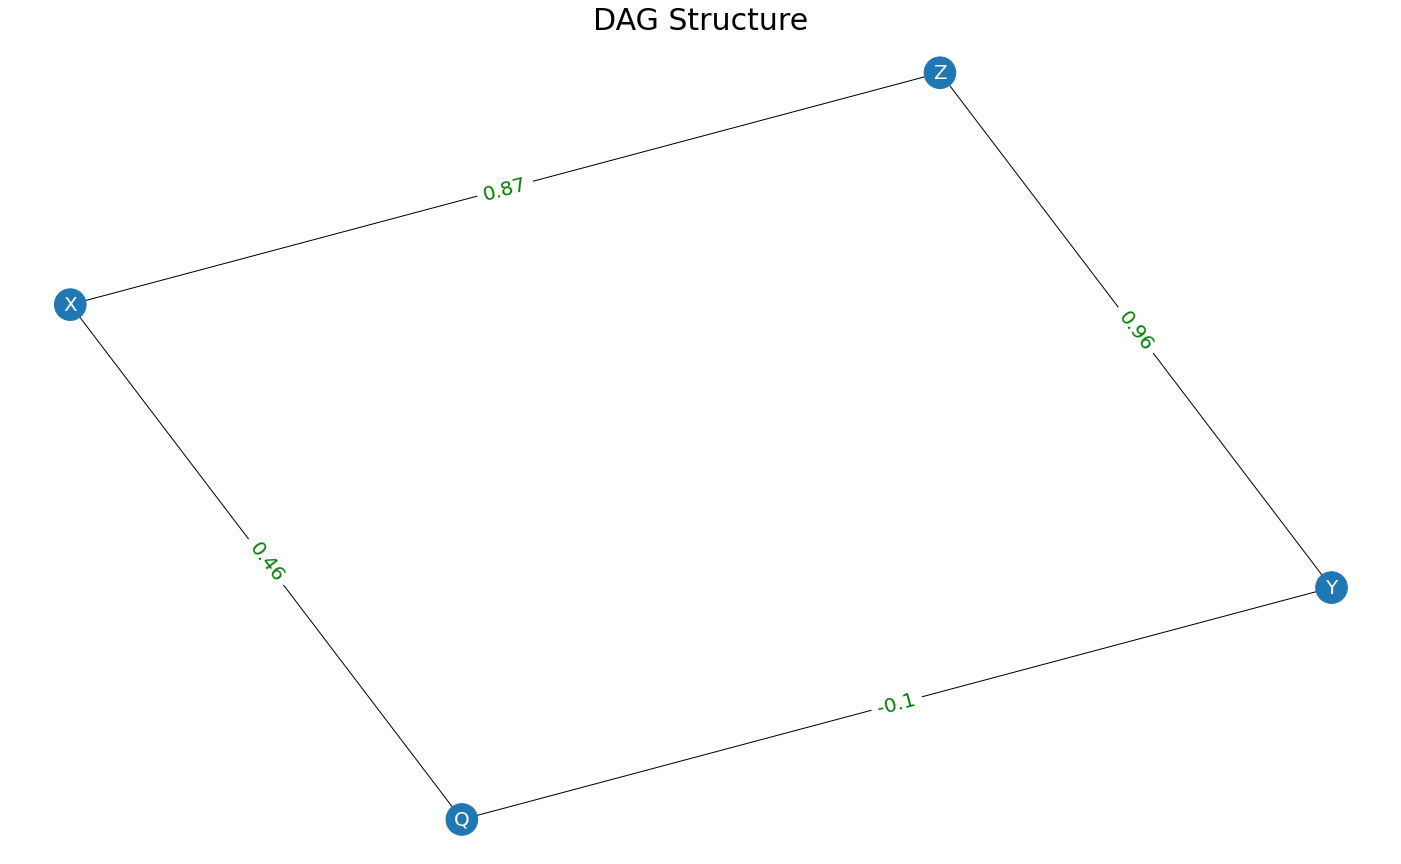

In [19]:
graph_DAG(undirected_graph, df, title = "DAG Structure")

In [23]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(keys) - 2


model = c.estimate(return_type = "dag",variant= "parallel", 
                   significance_level = 0.05, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()
pcorr = df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])

Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  8.73it/s]

('X', 'Z') : 0.865739073152477
('Y', 'Z') : 0.9571227537865387
('Q', 'X') : 0.45816054646330723
('Q', 'Y') : -0.09887886159943346


In [21]:
edges

OutEdgeView([('X', 'Z'), ('Y', 'Z'), ('Q', 'X')])

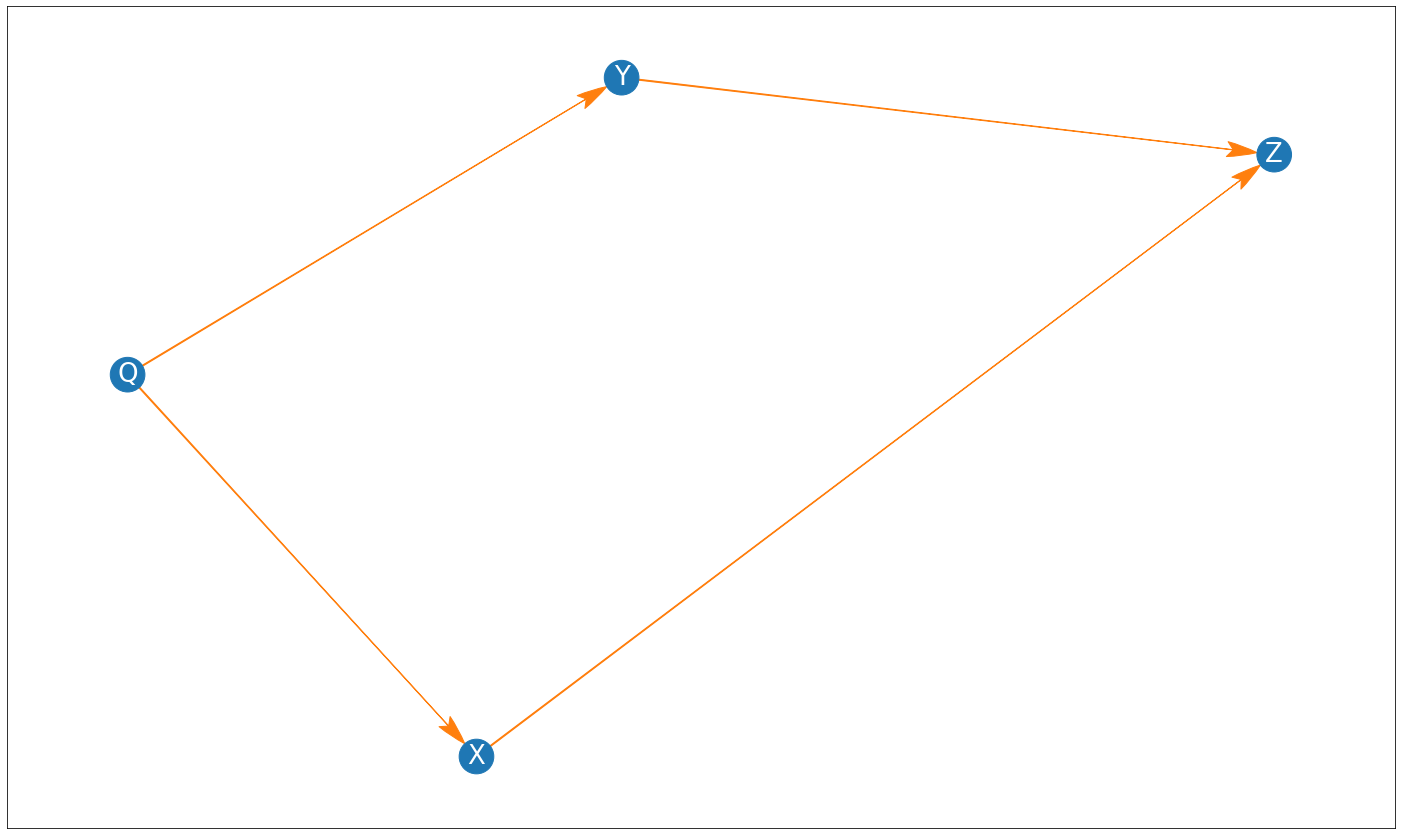

In [24]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    pcorr = df.pcorr()
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
        
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    #nx.draw_networkx_edge_labels(graph,pos,
    #                             edge_labels=edge_labels,
    #                             font_color='green',
    #                             font_size=20)

graph_DAG(edges, df)
    

In [10]:
def graph_stats(df, edges):
    statistics = {}
    for (node1, node2) in edges:
        covar = [node for node in df.keys() if node not in [node1, node2]]
        statistics[(node1, node2)] = df.partial_corr(x = node1, y = node2, covar=covar,
                        method = "pearson")
        statistics[(node1, node1)] = statistics[(node1, node2)]

        print(node1, node2, statistics[(node1, node2)], sep = "\n")
graph_stats(df, edges)

X
Z
            n         r         CI95%          p-val
pearson  1000  0.865739  [0.85, 0.88]  1.169074e-301
Y
Z
            n         r         CI95%  p-val
pearson  1000  0.957123  [0.95, 0.96]    0.0
Q
X
            n         r         CI95%         p-val
pearson  1000  0.458161  [0.41, 0.51]  6.063075e-53
